# Coffee in Manhattan

In a fix, which coffee chain is easier to find, Starbucks, or Dunkin? 

To answer that question, we will look at a list of all Dunkin' and Starbucks storefronts in Manhattan, and see the distance between each store and their nearest competitor.

In [1]:
import geopy.distance
import pandas as pd
import psycopg2

import sys
sys.path.append("../")
import private

def get_dataframe_from_db(query):

    with psycopg2.connect(private.AWS_CONNECTION_STRING) as conn:

        df = pd.read_sql(
            sql = query,
            con = conn
        )

    return df

def get_distance_between_stores(row):
    location_1 = (row['latitude_starbucks'], row['longitude_starbucks'])
    location_2 = (row['latitude_dunkin'], row['longitude_dunkin'])
    distance_between_stores = geopy.distance.distance(location_1, location_2).meters
    
    return round(distance_between_stores)

QUERY = '''
with base_data as (

    select
        vicinity as address,
        result_name,
        max(location_latitude) as latitude,
        max(location_longitude) as longitude,
        max(zip_code) as zip_code
    from locations_data.manhattan_starbucks
    group by 1,2
    union
    select
        vicinity as address,
        result_name,
        max(location_latitude) as latitude,
        max(location_longitude) as longitude,
        max(zip_code) as zip_code
    from locations_data.manhattan_dunkin
    group by 1,2
    )

select
    t.address as address_starbucks,
    t.latitude as latitude_starbucks,
    t.longitude as longitude_starbucks,
    t2.address as address_dunkin,
    t2.latitude as latitude_dunkin,
    t2.longitude as longitude_dunkin
from base_data as t
cross join base_data as t2
where t.result_name = 'Starbucks'
    and t2.result_name ~ 'Dunk'
    and t.address ~ 'New York'
    and t2.address ~ 'New York';
'''

df = get_dataframe_from_db(QUERY)
df['distance_between_stores'] = df.apply(get_distance_between_stores, axis = 1)

df.sort_values(by = ['distance_between_stores']).head()

/Users/b/anaconda2/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


,address_starbucks,latitude_starbucks,longitude_starbucks,address_dunkin,latitude_dunkin,longitude_dunkin,distance_between_stores
14435,"229 7th Ave, New York",40.744294,-73.995276,"225 7th Ave, New York",40.744251,-73.995319,6.0
112,"55 Liberty St, New York",40.708790,-74.009344,"49 Nassau St, New York",40.708937,-74.009265,18.0
8240,"875 3rd Ave, New York",40.757430,-73.969128,"875 3rd Ave, New York",40.757194,-73.969186,27.0
20216,"120 Church St, New York",40.713782,-74.009077,"130 Church St, New York",40.714031,-74.008954,30.0
3092,"130 Fulton St, New York",40.710194,-74.007894,"122 Fulton St, New York",40.709975,-74.007615,34.0


In [2]:
df['rank_starbucks'] = df.groupby('address_starbucks')['distance_between_stores'].rank(ascending=True)
df['rank_dunkin'] = df.groupby('address_dunkin')['distance_between_stores'].rank(ascending=True)

df_starbucks = df[df['rank_starbucks'] == 1]
df_dunkin = df[df['rank_dunkin'] == 1]

### Competitor Proximity Curves

What percent of each coffee chain operate without a competitor within N meters?

In [3]:
def share_of_stores_without_comp(df, distance):
    df['threshold_distance'] = ['yes' if x < distance else 'no' for x in df['distance_between_stores']]

    number_of_stores = df\
        .groupby('threshold_distance')['distance_between_stores']\
        .agg('count')['yes']
    
    total_stores = float(df.shape[0])
    
    return 1 - number_of_stores/total_stores

In [4]:
empty_list = []
for i in range(10, 250, 10):
    thing = {
        'distance': i,
        'starbucks': share_of_stores_without_comp(df_starbucks, i),
        'dunkin': share_of_stores_without_comp(df_dunkin, i)
    }
    empty_list.append(thing)
    
df_final = pd.DataFrame(empty_list)

/Users/b/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


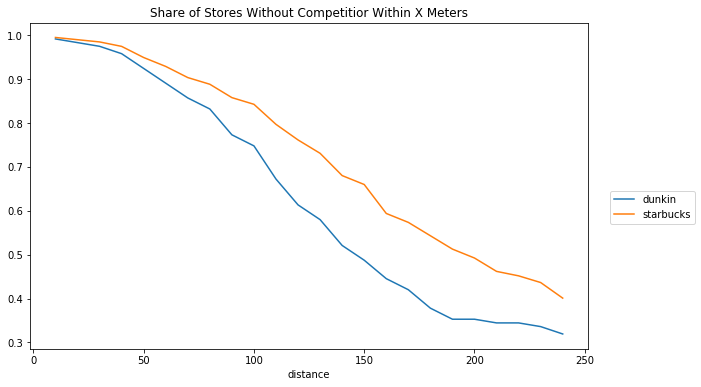

In [113]:
plot = df_final\
    .set_index('distance')\
    .plot(
        title = "Share of Stores Without Competitior Within X Meters", 
        figsize = (10,6))\
    .legend(bbox_to_anchor=(1.2, 0.5))

fig = plot.get_figure()
fig.savefig('competitor_proximity_curve.png')

### Zip Code Winners and Losers
Who has more stores in each zip code?

In [24]:
query_zip_codes = '''
with base_data as (

    select
        vicinity as address,
        result_name,
        max(location_latitude) as latitude,
        max(location_longitude) as longitude,
        max(zip_code) as zip_code
    from locations_data.manhattan_starbucks
    group by 1,2
    union
    select
        vicinity as address,
        result_name,
        max(location_latitude) as latitude,
        max(location_longitude) as longitude,
        max(zip_code) as zip_code
    from locations_data.manhattan_dunkin
    group by 1,2
    ),

long_data as (

    select
        zip_code,
        result_name as coffee_chain,
        count(*) as store_count
    from base_data
    group by 1,2
    order by 1,2
    ),

all_combos as (

    select
        t.zip_code,
        t2.result_name as coffee_chain
    from (select distinct zip_code from base_data) as t
    cross join (select distinct result_name from base_data where result_name !~ 'Baskin' and result_name !~ 'Donut') as t2
    ),

final_data as (

    select 
        t.zip_code,
        sum(case when t2.coffee_chain = 'Starbucks' then t2.store_count else 0 end) as starbucks,
        sum(case when t2.coffee_chain ~ 'Dunk' then t2.store_count else 0 end) as dunkin
    from all_combos as t
    left join long_data as t2 on t.zip_code = t2.zip_code and t.coffee_chain = t2.coffee_chain
    group by 1
    order by 1
    )

select
    zip_code,
    starbucks,
    dunkin,
    case
        when starbucks > 0 and dunkin = 0 then 'Starbucks Only'
        when starbucks = 0 and dunkin > 0 then 'Dunkin Only'
        when starbucks > dunkin then 'More Starbucks'
        when dunkin > starbucks then 'More Dunkin'
        when dunkin = starbucks then 'Draw'
    end as status
from final_data;
'''

df_coffee = get_dataframe_from_db(query_zip_codes)

df_coffee.head()

,zip_code,starbucks,dunkin,status
0,10001,4.0,0.0,Starbucks Only
1,10002,1.0,0.0,Starbucks Only
2,10005,2.0,0.0,Starbucks Only
3,10009,2.0,1.0,More Starbucks
4,10010,4.0,4.0,Draw


#### Get NYC GeoJSON data

In [95]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

url_nyc_geojson = 'http://data.beta.nyc//dataset/3bf5fb73-edb5-4b05-bb29-7c95f4a727fc/resource/6df127b1-6d04-4bb7-b983-07402a2c3f90/download/f4129d9aa6dd4281bc98d0f701629b76nyczipcodetabulationareas.geojson'
map_df = gpd.read_file(url_nyc_geojson)
manhattan_zip_codes = ['10026', '10027', '10030', '10037', '10039', '10001', '10011', '10018',
'10019', '10020', '10036', '10029', '10035', '10010', '10016', '10017', '10022', '10012', '10013', '10014',
'10004', '10005', '10006', '10007', '10038', '10280', '10002', '10003', '10009', '10021', '10028',
'10044', '10065', '10075', '10128', '10023', '10024', '10025', '10031', '10032', '10033', '10034', '10040']

manhattan_df = map_df[map_df['postalCode'].isin(manhattan_zip_codes)]

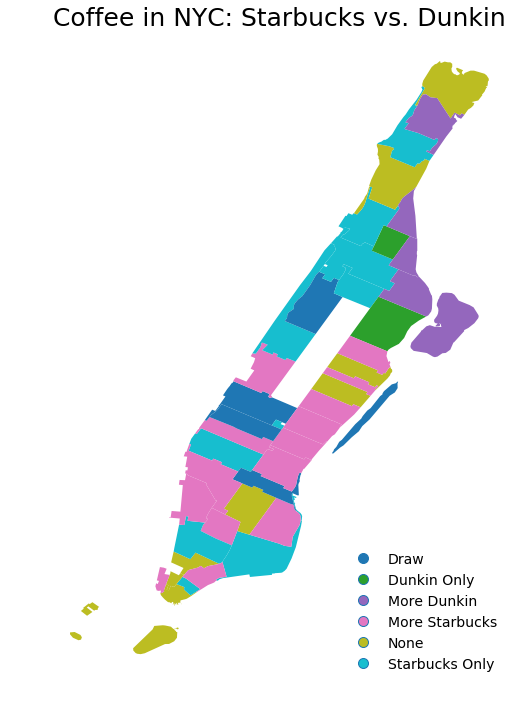

In [114]:
ax = manhattan_df\
    .set_index('postalCode')\
    .join(df_coffee.set_index('zip_code'))\
    .fillna('None')\
    .plot(
        column = 'status',
        figsize = (15,12),
        legend = True,
        legend_kwds={
            'loc': 'lower right',
            'fontsize': 14,
            'frameon': False}
)

ax.set_title('Coffee in NYC: Starbucks vs. Dunkin', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})
ax.axis('off')

plot = ax
fig = plot.get_figure()
fig.savefig('zip_code_winners.png')